In [ ]:
#Please enter your twitter keys

library(twitteR)
library(ggmap)
library(dplyr)

api_key <- ''
api_secret <- ''
access_token <- ''
access_secret <- ''
 
setup_twitter_oauth(api_key,api_secret,access_token,access_secret)


For the search term '#SuperBowl', data has been already collected and is present in the same folder as SuperBowl.csv.
So for the '#SuperBowl' output, just scroll down to the end.
For different searchterm, please hardcode and then run! 
I have 2 outputs, one plotted by cities and one plotted by states, at the end.

In [60]:
searchterm <- '#SuperBowl'
tweets <- searchTwitter(searchterm,n=1000)

tweetsDF <- twListToDF(tweets)
users <- lookupUsers(tweetsDF$screenName)
usersDF <- twListToDF(users)

userswithloc <- !is.na(usersDF$location)
usersloc <- usersDF$location[userswithloc]
locations <- geocode(usersloc)
locations <- na.omit(locations)
nrow(locations)

# Writing collected location coordinates in to .csv file
# Writing data to a new 'searchterm'.csv file. If same searchterm is used again, data is appended to the existing file.
                                                     

filename <- substr(searchterm, 2, nchar(searchterm))
myfile <- file.path(paste0(filename, ".csv"))
write.table(file=myfile, locations,sep=',',append=T) 


Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Los%20Angeles&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Argentina&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=USA&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=19.11.13&sensor=false
Warning message:
"geocode failed with status ZERO_RESULTS, location = "19.11.13""Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Hong%20Kong&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Fort%20Worth,%20TX&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Anzoategui-Venezuela&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Burbank,%20California&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geoco

[1] 316

Warning message in write.table(file = myfile, locations, sep = ",", append = T):
"appending column names to file"

Reading from the .csv file created

In [118]:
coordinates = read.csv(file=myfile,row.names=NULL,stringsAsFactors = FALSE)
coordinates$lon <- as.numeric(coordinates$lon)
coordinates$lat <- as.numeric(coordinates$lat)
coordinates <- as.data.frame(coordinates)
coordinates <- subset(coordinates, select = c('lon','lat'))
coordinates <-na.omit(coordinates) 

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

Grouping matching coordinates

In [119]:
grpcoord = as.data.frame(group_by(coordinates, lon, lat) %>% count(lon, lat)) 

Plotting the map, using the grouped coordinates, bigger the blob, more tweets from that location

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=29.763284,-95.363271&zoom=4&size=640x640&scale=2&maptype=terrain&sensor=false
Warning message:
"Removed 429 rows containing missing values (geom_point)."

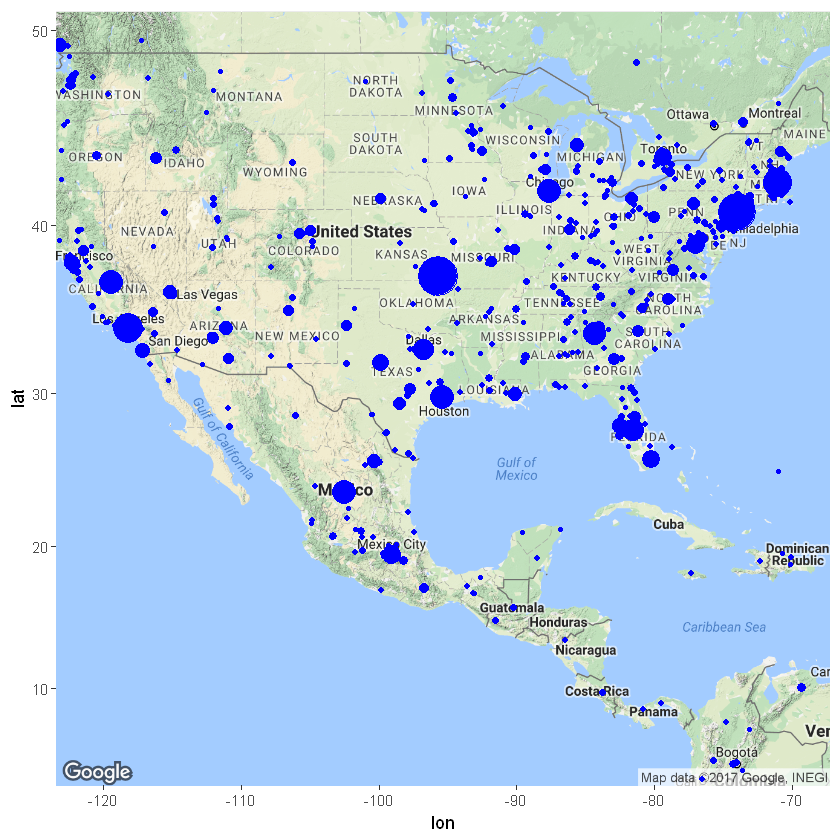

In [120]:
USAmap <- ggmap(get_googlemap(location='united states',zoom=4))
USAmap + geom_point(data = grpcoord,aes(x=grpcoord$lon,y=grpcoord$lat), color='blue',size=sqrt(grpcoord$n))

The following function latlong2state is taken from stackoverflow, as it perfectly served my requirement of converting coordinates to states.
Stackoverflow link: http://stackoverflow.com/questions/8751497/latitude-longitude-coordinates-to-state-code-in-r

In [121]:
latlong2state <- function(pointsDF) {
    # Prepare SpatialPolygons object with one SpatialPolygon
    # per state (plus DC, minus HI & AK)
    states <- map('state', fill=TRUE, col="transparent", plot=FALSE)
    IDs <- sapply(strsplit(states$names, ":"), function(x) x[1])
    states_sp <- map2SpatialPolygons(states, IDs=IDs,
                     proj4string=CRS("+proj=longlat +datum=WGS84"))

    # Convert pointsDF to a SpatialPoints object 
    pointsSP <- SpatialPoints(pointsDF, 
                    proj4string=CRS("+proj=longlat +datum=WGS84"))

    # Use 'over' to get _indices_ of the Polygons object containing each point 
    indices <- over(pointsSP, states_sp)

    # Return the state names of the Polygons object containing each point
    stateNames <- sapply(states_sp@polygons, function(x) x@ID)
    stateNames[indices]
}

states <- latlong2state(coordinates) # End of code taken from stackoverflow
states <- na.omit(states)
statesDF <- as.data.frame(table(states))

In [122]:
stateslatlon <- geocode(as.character(statesDF$states),source='dsk')
stateslatlonDF <- as.data.frame(cbind(statesDF$states,stateslatlon))

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=29.763284,-95.363271&zoom=4&size=640x640&scale=2&maptype=terrain&sensor=false


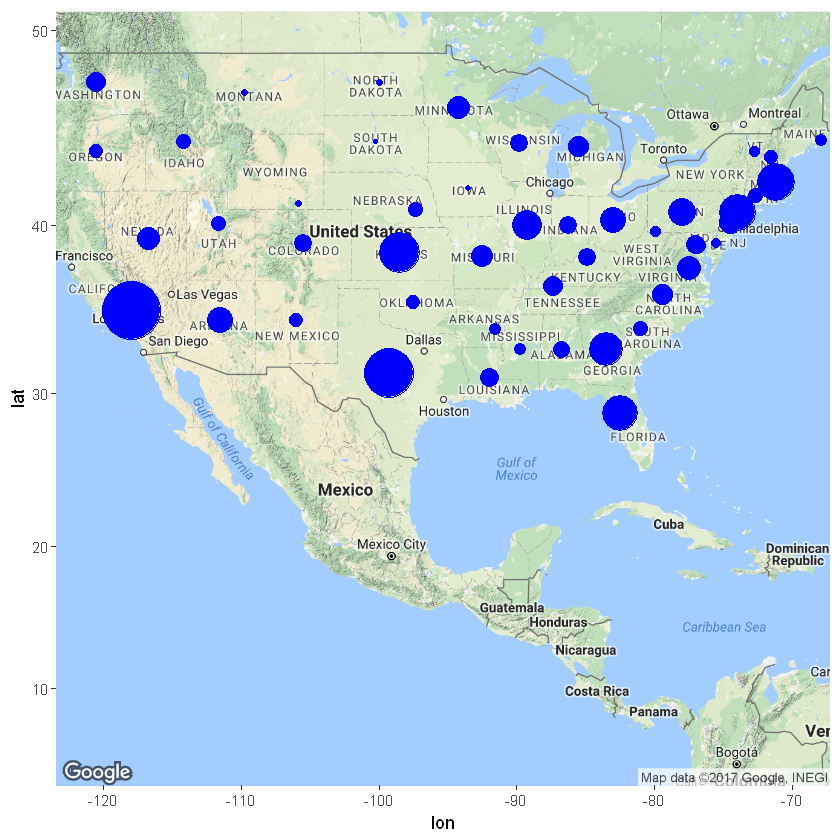

In [123]:
USAmap <- ggmap(get_googlemap(location='united states', zoom=4))
USAmap + geom_point(data = stateslatlon,aes(x=stateslatlon$lon,y=stateslatlon$lat), color='blue',size=sqrt(statesDF$Freq))